# ENTRENAMIENTO - FEATURE ENGINEER

El objetivo del presente notebook consiste en analizar las variables a un nivel que permita evaluar como se pueden transformar o que relación tienen con otras variables, para mejorar la capacidad de un modelo de explicar la variable de respuesta.

## SET UP

In [1]:
!pip install findspark

import findspark
findspark.init()

## LIBRERIAS

In [2]:
# Cargar Pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql.functions import *

spark = SparkSession.builder.appName("feature_engineer").master("local[*]").getOrCreate()

In [3]:
from pyspark.sql.functions import *
from pyspark.sql import Window
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression 
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.util import MLUtils

In [4]:
#https://stackoverflow.com/questions/55546467/how-to-plot-correlation-heatmap-when-using-pysparkdatabricks
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')

## CARGAR DATOS

In [6]:
# Path definition
path = "output/preprocessing/preprocessing_data.parquet"

In [7]:
# Read dataframe
train = spark.read.parquet(path, header= True, inferSchema=True)
train = train.withColumnRenamed("categoria","grupo")

In [8]:
# Cast binary variables
train = (train
         .withColumn("ind_mora_vigente",col("ind_mora_vigente").cast("integer"))
         .withColumn("cartera_castigada",col("cartera_castigada").cast("integer"))
         .withColumn("tenencia_tc",col("tenencia_tc").cast("integer"))
         .withColumn("tiene_consumo",col("tiene_consumo").cast("integer"))
         .withColumn("tiene_crediagil",col("tiene_crediagil").cast("integer"))
         .withColumn("tiene_ctas_activas",col("tiene_ctas_activas").cast("integer"))
         .withColumn("tiene_ctas_embargadas",col("tiene_ctas_embargadas").cast("integer"))
         .withColumn("tiene_cred_hipo_1",col("tiene_cred_hipo_1").cast("integer"))
         .withColumn("tiene_cred_hipo_2",col("tiene_cred_hipo_2").cast("integer"))
         .withColumn("pension_fopep",col("pension_fopep").cast("integer"))
        )

In [9]:
# Verify rows
train.count()

9670308

In [10]:
train.limit(5).toPandas().head()

,periodo,id_cli,fecha_nacimiento,edad,estado_civil,nivel_academico,tipo_vivienda,grupo,ind_mora_vigente,cartera_castigada,...,Pensionado,Indefinida,Desempleado,ANDINA,PACIFICO,EXTERIOR,CARIBE,ORINOQUIA,NI,AMAZONIA
0,202002,6243935,19960501,24.0,1,4,0,2.0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,201910,8685012,19801213,39.0,2,5,1,4.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,202002,8685012,19801213,39.0,2,5,1,4.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,202002,1003141,19910603,29.0,1,2,2,1.0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,202003,1003141,19910603,29.0,1,2,2,1.0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [11]:
# Clean input variables
input_values = train.columns
drop_values = ['grupo','periodo','id_cli','fecha_nacimiento','ult_actual','codigo_ciiu','profesion']
input_numericas = [x for x in input_values if x not in drop_values]

## ANÁLISIS MULTIVARIADO

### Correlaciones entre variables continuas

In [12]:
# Vectorize variables to define the features column
feat_vector = VectorAssembler(inputCols=input_numericas, outputCol= "features")

In [13]:
# Appply vectorization to train
transTrain = feat_vector.transform(train)

In [14]:
matrix = Correlation.corr(transTrain, "features").collect()[0][0]
corrmatrix = matrix.toArray().tolist()

In [15]:
correlation_df = spark.createDataFrame(corrmatrix,input_numericas).toPandas()

In [16]:
index_df = pd.DataFrame(input_numericas,columns=["variables"])

In [17]:
matrix_correlations = pd.merge(index_df, correlation_df, left_index=True, right_index=True).set_index("variables")

In [18]:
matrix_correlations = matrix_correlations.round(2)

In [22]:
correlation_target = matrix_correlations[["gasto_familiar"]].sort_values(by="gasto_familiar")

In [23]:
pd.set_option('display.max_rows', None)
display(correlation_target)

,gasto_familiar
variables,
cat_ingreso,-0.06
ingreso_nompen,-0.04
mediana_nom3,-0.04
ingreso_nomina,-0.03
Estudiante,-0.03
Empleado,-0.03
nivel_academico,-0.02
Pensionado,-0.02
tenencia_tc,-0.02


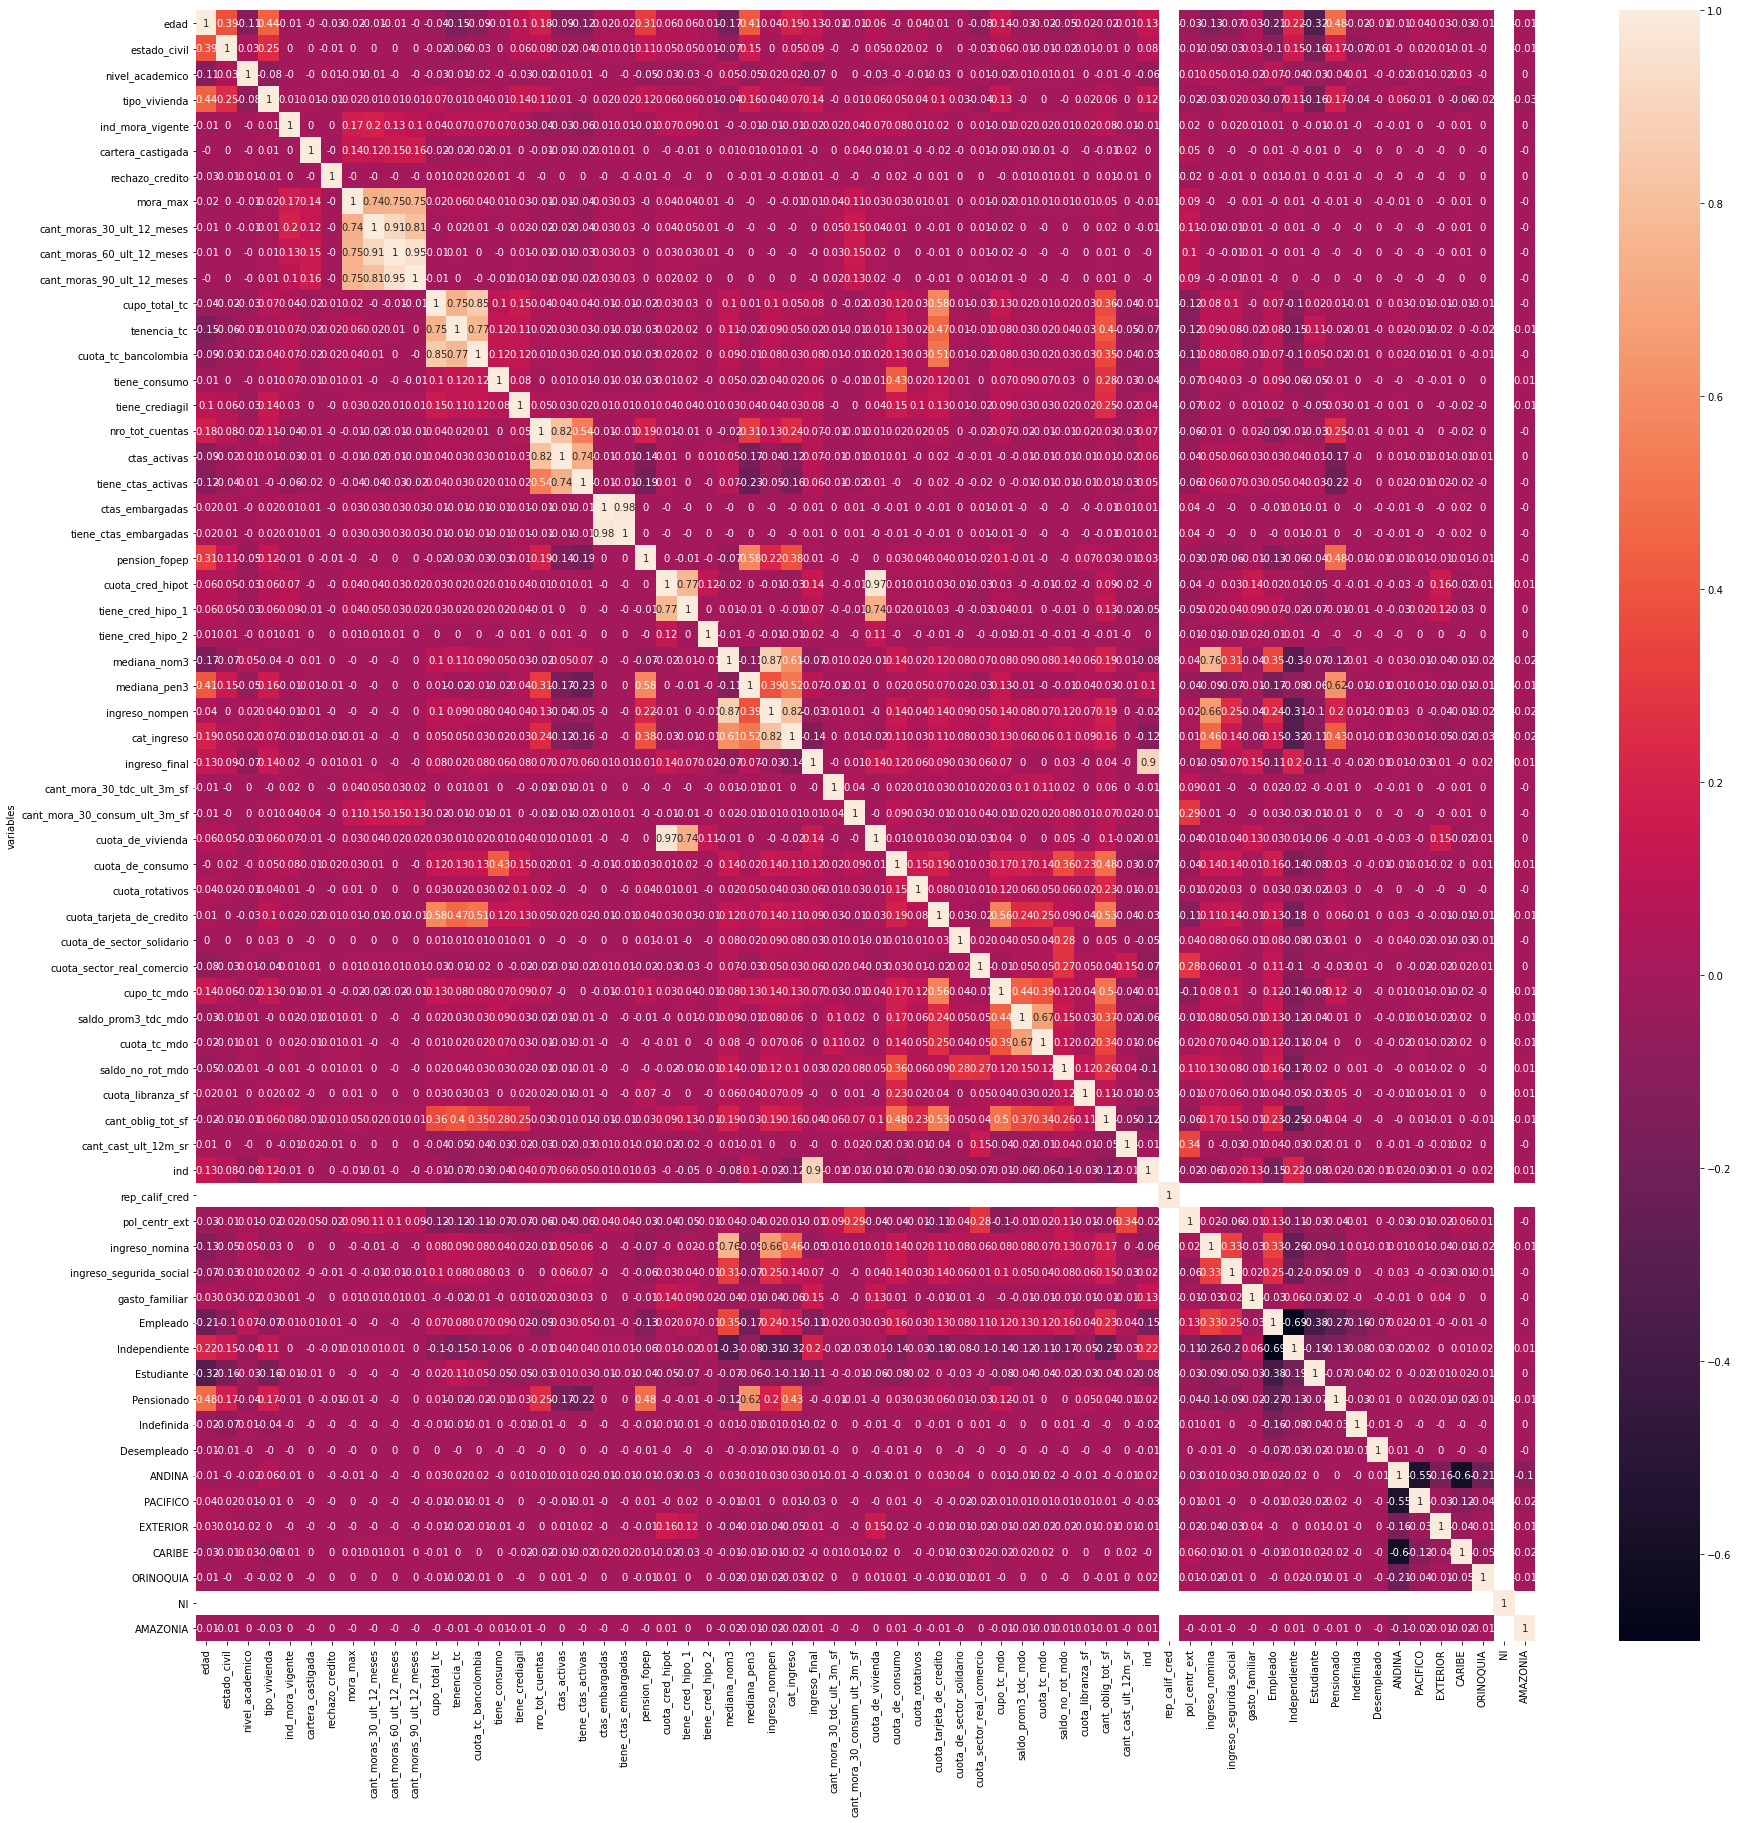

In [24]:
plt.figure(figsize=(30,30))
sns.heatmap(matrix_correlations, annot=True)

In [25]:
matrix_correlations.to_csv("output/statistics/matrix_correlations.csv")